# Text2Chart


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

## 3. Analysis

In [7]:
import io
import pprint
import base64
import traceback
from PIL import Image
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict, Literal, Any
from src.genai_anaysis import llm_call
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool

### 3.1 Agent state 

In [8]:
class GraphState(TypedDict):
    ask: list[str]
    target_apps: list[str]
    ask_refo: str
    code: str
    code_err: str
    img_path: str
    img_bytes: str
    chart_desc: str
    prev_node: str

In [49]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm = kwargs["llm"]
        self.df = kwargs["df"]
        self.column_info = kwargs["column_info"]
        self.state = GraphState

        self.llm_caller = llm_call(llm=self.llm, verbose=False) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, img=None):
        
        message = {
            "role": role,
            "content": [{"text": dedent(string)}]
        }
        
        if img is not None:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

        return message

    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_image(base64_string):
        try:
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))
            
            # matplotlib을 사용하여 이미지 표시
            plt.imshow(image)
            plt.axis('off')  # 축 제거
            plt.show()
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def agent(state):

            print("---CALL AGENT---")
            ask = state["ask"]

            """
            현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                state (messages): 현재 상태 메시지에 에이전트 응답이 추가된 업데이트된 상태
            """

            system_prompts = dedent(
                '''
                <task>
                사용자 메시지를 분석하여 차트 생성 여부를 결정하는 에이전트 역할 수행
                </task>
                
                <instruction>
                1. 사용자 메시지를 주의 깊게 분석하세요.
                2. 차트, 그래프, 데이터 시각화와 관련된 키워드를 찾으세요.
                3. 수치 데이터나 통계 정보의 존재 여부를 확인하세요.
                4. 분석 결과를 바탕으로 차트 생성 필요성을 판단하세요.
                5. 판단이 모호한 경우, 사용자에게 직접 차트 생성 의도를 물어보세요.
                </instruction>
                
                <consideration>
                - 사용자의 의도를 정확히 파악하는 것이 중요합니다.
                - 명시적인 차트 요청이 없더라도 데이터 시각화가 유용할 수 있는 상황을 고려하세요.
                - 주어진 데이터 (dataset) 및 컬럼 정보 (column_info)를 참고하여 생성 가능 여부 또한 고려하세요.
                - 단순한 질문이나 대화 종료 요청은 차트 생성이 불필요할 수 있습니다.
                - 기존 요청 결과에 대한 추가사항이라고 판단되면, 추가 코드 생성을 하지 말고 "GENERATE_CHART"를 출력하세요.
                </consideration>
                
                <output_format>
                결정에 따라 다음 중 하나를 출력하세요:
                1. "GENERATE_CHART (간단한 이유)" - 차트 생성이 필요한 경우
                2. "END (간단한 이유)" - 차트 생성이 불필요하거나 대화를 종료해야 하는 경우
                
                예시:
                GENERATE_CHART (사용자가 연간 수익 추이 그래프 요청)
                END (단순한 날씨 질문으로 차트 불필요)
                </output_format>

                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                
                '''
            )

            context = {
                "dataset": str(self.df.sample(10, random_state=0).to_csv()),
                "column_info": str(self.column_info.to_csv())
            }
            system_prompts = system_prompts.format(**context)
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            

            message = self._get_message_from_string(role="user", string=ask)
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            
            return self.state(ask=ask, prev_node="AGENT")

        def should_chart_generation(state):
            """
            에이전트가 차트를 생성하는데 있어 추가적으로 고려해야 하는 상황이 있는지 결정합니다.
        
            이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
            """
        
            print("\n---DECIDE TO CHART GENERATION---")
            #messages = state["messages"]
            last_message = self._get_string_from_message(self.messages[-1])
            
            # 함수 호출이 없으면 종료합니다.
            if "GENERATE_CHART" not in last_message:
                print("---DECISION: DO NOT CHART GENERATION / DONE---")
                return "end"
            # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
            else:
                print("---DECISION: CHART GENERATION---")
                return "continue"

        def ask_reformulation(state):

            print("---ASK REFORMULATION---")
            ask = state["ask"]

            system_prompts = dedent(
                '''
                당신은 사용자의 텍스트 요청을 분석하여 중요한 정보를 추출하는 전문가입니다.
                주어진 structured dataset(df)에 대한 분석 요청(request)을 처리하는 것이 당신의 주요 임무입니다.

                <task>
                1. 사용자의 텍스트 요청에서 분석 대상이 되는 target app의 이름을 식별하고 추출하세요.
                2. 사용자의 구체적인 분석 요청 사항을 분석하고, 필요하다면 결과를 차트로 표현하기 적합현 형태로 요청 사항을 수정해 주세요.
                </task>
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {{
                  "target_apps": ["추출된 앱 이름"],
                  "ask_reformulation": "파악된 분석 요청 사항"
                }}
                </output_format>

                <instruction>
                - target app이 명시적으로 언급되지 않은 경우, "target_app" 필드를 "unspecified"로 설정하세요.
                - target app이 복수 개인 경우, list 형태로 모두 언급하세요. 예를 들자면 ["앱 이름 1", "앱 이름 2"]로 표현합니다. 
                - 분석 요청이 불명확한 경우, 가능한 한 사용자의 의도를 추론하여 "ask_reformulation" 필드를 작성하세요.
                - 추출 및 파악한 정보만을 간결하게 제공하고, 추가적인 설명이나 해석은 하지 마세요.
                </instruction>

                이 정보를 바탕으로 다음 노드가 적절한 분석을 수행할 수 있도록 정확하고 명확한 정보를 제공하는 것이 중요합니다.
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>
                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                Here is user's request: <request>{ask}</request>
                '''
            )
            context = {
                "dataset": str(self.df.sample(10, random_state=0).to_csv()),
                "column_info": str(self.column_info.to_csv()),
                "ask": ask
            }
            user_prompts = user_prompts.format(**context)
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)

            results = eval(resp['text'])
            target_apps, ask_reformulation = results["target_apps"], results["ask_reformulation"]
            self.messages=messages_updated

            return self.state(target_apps=target_apps, ask_refo=ask_reformulation, prev_node="ASK_REFORMULATION")

        def code_generation_for_chart(state):

            print("---CODE GENERATION FOR CHART---")
            ask_reformulation = state["ask_refo"]
            previous_node = state["prev_node"]
            code_error = state["code_err"]

            system_prompts = dedent(
                '''
                당신은 데이터 분석과 시각화 전문가입니다.
                주어진 structured dataset, dataset의 컬럼 정보, 그리고 사용자의 분석 요청사항을 바탕으로 적절한 차트를 생성하는 Python 코드를 작성하는 것이 당신의 임무입니다.

                <task>
                사용자의 요청에 적합한 차트생성 python 코드 작성
                </task>

                <input>
                1. dataset: 분석할 데이터셋
                2. column_info: 각 컬럼의 이름과 데이터 타입
                3. question: 어떤 분석을 원하는지에 대한 설명
                </input>
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요:
                {{
                    "code": """사용자의 요청을 충족시키는 차트를 생성하는 Python 코드"""
                    "img_path": """생성된 차트의 저장 경로"""
                }}
                </output_format>

                <instruction>
                1. 데이터셋과 컬럼 정보를 신중히 분석하세요.
                2. 사용자의 분석 요청사항을 정확히 이해하세요.
                3. 요청사항에 가장 적합한 차트 유형을 선택하세요 (예: 막대 그래프, 선 그래프, 산점도, 파이 차트 등).
                4. 선택한 차트 유형에 맞는 Python 라이브러리를 사용하세요 (예: matplotlib, seaborn, plotly 등).
                5. 데이터 전처리가 필요한 경우 pandas를 사용하여 데이터를 적절히 가공하세요.
                6. 차트의 제목, 축 레이블, 범례 등을 명확하게 설정하세요.
                7. 필요한 경우 차트의 색상, 스타일, 크기 등을 조정하여 가독성을 높이세요.
                8. 코드에 주석을 달아 각 단계를 설명하세요.
                9. 코드 실행 시 발생할 수 있는 예외 상황을 고려하여 적절한 예외 처리를 포함하세요.
                10. 생성된 차트를 저장하거나 표시하는 코드를 포함하세요.
                11. 생성된 코드 수행에 필요한 패키지들은 반드시 import 하세요.
                12. 차트는 모두 영어로 표현해 주세요.
                </instruction>

                <consideration>
                1. 사용자가 제공한 데이터셋의 구조와 크기에 따라 코드를 최적화하세요.
                2. 복잡한 분석 요청의 경우, 단계별로 접근하여 중간 결과를 확인할 수 있도록 코드를 구성하세요.
                3. 데이터의 특성에 따라 적절한 정규화나 스케일링을 고려하세요.
                4. 대규모 데이터셋의 경우 성능을 고려하여 코드를 작성하세요.
                5. "plt.style.use('seaborn')" 코드는 사용하지 마세요.
                6. python의 string code 수행방법(exec())을 사용하려고 합니다. "unterminated string literal" 에러가 발생하지 않게 코드를 작성하세요.\n
                7. 코드가 길어 다음 라인에 연속해서 작성해야 하는 경우, backslash(\)를 사용하여 라인을 연결하세요.
                8. 이 지침을 따라 사용자의 요청에 맞는 정확하고 효과적인 차트 생성 코드를 작성하고, JSON 형식으로 출력하세요.
                9. 차트는 show()함수를 통해 시각화하며, "./output/chart.png"로 저장하고, 경로는 output_format에 맞춰 저장하세요.
                10. 만약 코드 수행에 대한 에러(<error_log>가 주어질 경우, 에러를 고려해서 코드를 수정하세요.
                </consideration>
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>
                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                Here is the question: <ask>{ask}</ask>
                Here is the error log: <error_log>{error_log}</error_log>
                Variable `df: pd.DataFrame` is already declared.
                
                '''
            )

            context = {
                "dataset": str(self.df.sample(10, random_state=0).to_csv()),
                "column_info": str(self.column_info.to_csv()),
                "ask": ask_reformulation,
                "error_log": "None" if code_error == "None" else code_error
            }
            user_prompts = user_prompts.format(**context)

            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated

            results = eval(resp['text'])
            code, img_path = results["code"], results["img_path"]

            return self.state(code=code, img_path=img_path, prev_node="CODE_GENERATION")

        def chart_generation(state):

            print("---CHART GENERATION---")
            df, code = self.df, state["code"]

            try:
                results = exec(code, {"df": df})
                return self.state(code_err="None", prev_node="CHART_GENERATION")
                
            except Exception as e:
                error_type = type(e).__name__
                error_message = str(e)
                error_traceback = traceback.format_exc()

                error = f"Error Type: {error_type}\nError Message: {error_message}\n\nTraceback:\n{error_traceback}"
                print (f"error: {error}")
                return self.state(code_err=error, prev_node="CHART_GENERATION")

        def code_checker(state):

            print("---CODE CHECKER---")
            code_error = state["code_err"]

            if code_error == "None":
                print ("---GO TO CHART DESCRIPTION---")
                return "continue"
            else:
                print ("---[ERROR] GO TO CODE REWRITE---")
                return "rewrite"
            
        def chart_description(state):

            print("---CHART DESCRIPTION---")
            img_path = state["img_path"] # PNG 파일 경로

            system_prompts = dedent(
                '''
                 <task>
                 사용자의 요청(ask)에 따라 생성된 차트(PNG 형식)를 분석하고 설명합니다. 사용자의 원래 요청을 고려하여 차트의 내용을 정확하고 상세하게 해석하고, 관련 인사이트를 제공합니다.
                 </task>
                 
                <output_format>
                다음 정보를 포함하여 응답하세요:
                1. 차트 개요: 차트 유형과 전반적인 구조 설명
                2. 데이터 분석: 주요 데이터 포인트, 추세, 패턴 설명
                3. 사용자 요청 연관성: 차트가 사용자의 요청을 어떻게 충족시키는지 설명
                4. 주요 인사이트: 차트에서 도출할 수 있는 중요한 결론이나 통찰
                5. 한계점 및 추가 고려사항: 차트의 제한사항이나 추가 분석 필요성
                6. 요약 및 결론: 분석의 핵심 포인트와 사용자 요청에 대한 직접적인 답변
                </output_format>

                <instruction>
                1. 사용자의 요청(ask) 분석:
                    - 사용자가 얻고자 하는 정보와 주요 키워드 파악
                2. 차트 유형 식별:
                    - 차트 유형 파악 및 사용자 요청과의 적절성 평가
                3. 데이터 분석:
                    - 주요 데이터 포인트, 추세, 패턴, 이상치 관찰
                    - 관련 통계 정보 파악 (최대값, 최소값, 평균 등)
                4. 차트 구성 요소 설명:
                    - x축, y축, 범례, 제목, 라벨 등의 의미 해석
                5. 사용자 요청과의 연관성 설명:
                    - 차트가 사용자 요청을 어떻게 충족시키는지 구체적으로 설명
                6. 인사이트 도출:
                    - 차트에서 볼 수 있는 주요 인사이트나 결론 제시
                    - 데이터의 의미를 사용자 요청 맥락에서 해석
                7. 한계점 및 추가 고려사항 언급:
                    - 차트의 한계점이나 누락된 정보 지적
                    - 추가 분석이나 데이터 필요성 제안
                8. 요약 및 결론 제시:
                    - 분석의 핵심 포인트 요약
                    - 사용자의 원래 요청에 대한 직접적인 답변 제공
                </instruction>
                
                <consideration>
                1. 객관적이고 중립적인 톤을 유지하며, 데이터에 기반한 설명 제공
                2. 전문 용어 사용 시 필요에 따라 간단한 설명 추가
                3. 사용자의 추가 질문 가능성을 고려하여 상세한 설명이 필요한 부분 명시
                4. 차트나 데이터의 품질 문제가 있을 경우 적절히 지적
                5. 사용자의 요청과 관련성이 낮은 차트 세부사항은 간략히 다루거나 생략
                6. 시각적 요소(색상, 크기 등)가 데이터 해석에 중요한 경우 이를 언급
                7. 가능한 경우, 차트에서 얻은 정보를 실제 상황이나 의사결정에 적용하는 방법 제안
                8. 차트가 표현하는 데이터의 출처나 시간 범위가 중요한 경우 이를 강조
                9. chart description 생성 시 '"' 사용하지 말 것. 
                </consideration>
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                Here is chart: 
                '''
            )

            context = {
                "ask": ask_reformulation
            }
            user_prompts = user_prompts.format(**context)
            
            self.img_bytes, img_base64 = self._png_to_bytes(img_path)
            message = self._get_message_from_string(role="user", string=user_prompts, img=self.img_bytes)
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            chart_description = self._get_string_from_message(self.messages[-1])
             
            return self.state(chart_desc=chart_description, prev_node="CHART_DESCRIPTION")
            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_node("ask_reformulation", ask_reformulation)  # 요청을 차트생성에 용이하게 수정하는 노드를 추가합니다.
        workflow.add_node("code_generation_for_chart", code_generation_for_chart)  # 차트 생성을 위한 코드 생성 노드를 추가합니다.
        workflow.add_node("chart_generation", chart_generation)  # 생성된 코드를 실행하여 노드를 생성하는 노드를 추가합니다.
        workflow.add_node("chart_description", chart_description)  # 생성된 코드를 설명하는 노드를 추가합니다.
        
        # 각 노드들을 연결합니다.
        workflow.add_conditional_edges(
            "agent",
            # 에이전트 결정 평가
            should_chart_generation,
            {
                # 도구 노드 호출
                "continue": "ask_reformulation",
                "end": END,
            },
        )
        workflow.add_edge("ask_reformulation", "code_generation_for_chart")
        workflow.add_edge("code_generation_for_chart", "chart_generation")
        workflow.add_conditional_edges(
            "chart_generation",
            # 에이전트 결정 평가
            code_checker,
            {
                # 도구 노드 호출
                "continue": "chart_description",
                "rewrite": "code_generation_for_chart",
            },
        )
        #workflow.add_edge("chart_generation", "chart_description")
        workflow.add_edge("chart_description", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Chart"})

    def invoke(self, **kwargs):
        
        inputs = self.state(ask=kwargs["ask"])
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [50]:
import pandas as pd
from langgraph.graph import END, StateGraph

In [51]:
df = pd.read_csv("./dataset/app_power_consumption.csv")
column_info = pd.read_csv("dataset/column_info.csv")

In [52]:
analyzer = genai_analyzer(
    llm=llm_text,
    df=df,
    column_info=column_info
)

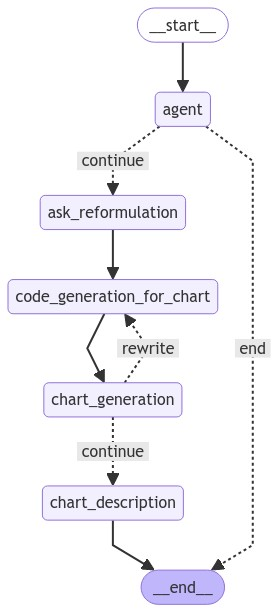

In [53]:
analyzer.show_graph()

---CALL AGENT---
GENERATE_CHART (사용자가 앱 a, b, c의 전력 소비 비교 차트를 요청했으며, 데이터셋에 해당 정보가 포함되어 있음)
---DECIDE TO CHART GENERATION---
---DECISION: CHART GENERATION---
"Output from node 'agent':"
'---'
{'ask': '지난 주 앱a, b, c 소비 전력에 대한 비교 차트', 'prev_node': 'AGENT'}
'\n---\n'
---ASK REFORMULATION---
{
  "target_apps": ["app_a", "app_b", "app_c"],
  "ask_reformulation": "지난 주 app_a, app_b, app_c의 소비 전력을 비교하는 차트 생성"
}"Output from node 'ask_reformulation':"
'---'
{ 'ask_refo': '지난 주 app_a, app_b, app_c의 소비 전력을 비교하는 차트 생성',
  'prev_node': 'ASK_REFORMULATION',
  'target_apps': ['app_a', 'app_b', 'app_c']}
'\n---\n'
---CODE GENERATION FOR CHART---
{
    "code": """
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Convert '날짜' column to datetime
df['날짜'] = pd.to_datetime(df['날짜'])

# Get the date of the last day in the dataset
last_date = df['날짜'].max()

# Calculate the start date of the last week
start_date = last_date - timedelta(days=6)

# Filter the dataf

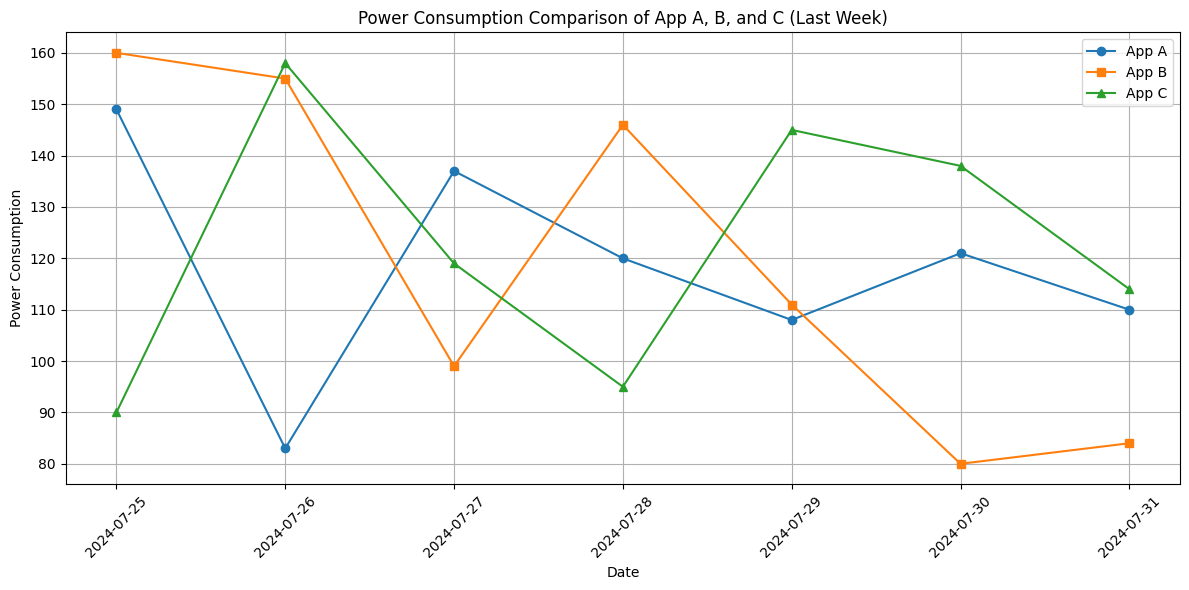

---CODE CHECKER---
---GO TO CHART DESCRIPTION---
"Output from node 'chart_generation':"
'---'
{'code_err': 'None', 'prev_node': 'CHART_GENERATION'}
'\n---\n'
---CHART DESCRIPTION---
1. 차트 개요:
이 차트는 지난 주(2024년 7월 25일부터 7월 31일까지) App A, B, C의 일일 전력 소비량을 비교하는 선 그래프입니다. 각 앱은 서로 다른 색상과 마커로 표시되어 있어 쉽게 구분할 수 있습니다.

2. 데이터 분석:
- App A: 전력 소비량이 84에서 149 사이로 변동하며, 주 초반에 큰 폭의 변동을 보입니다.
- App B: 80에서 160 사이의 넓은 범위로 변동하며, 주 초반에 높은 소비량을 보이다가 주 후반에 급격히 감소합니다.
- App C: 90에서 158 사이로 변동하며, 주 중반에 가장 낮은 소비량을 기록한 후 다시 증가하는 추세를 보입니다.

3. 사용자 요청 연관성:
이 차트는 사용자가 요청한 대로 지난 주 App A, B, C의 전력 소비량을 일별로 비교하여 보여주고 있습니다. 각 앱의 소비 패턴과 변동을 명확히 볼 수 있어 요청을 충실히 반영하고 있습니다.

4. 주요 인사이트:
- App B가 주 초반에 가장 높은 전력 소비를 보이다가 주 후반에 가장 낮은 소비량을 기록하는 극단적인 변화를 보입니다.
- App C는 중반에 급격한 감소 후 다시 증가하는 V자 형태의 패턴을 보입니다.
- App A는 다른 두 앱에 비해 상대적으로 안정적인 소비 패턴을 보이지만, 여전히 상당한 변동이 있습니다.
- 7월 26일에는 세 앱 모두 높은 전력 소비를 기록했습니다.

5. 한계점 및 추가 고려사항:
- 일주일간의 데이터만으로는 장기적인 추세를 파악하기 어렵습니다. 더 긴 기간의 데이터가 있다면 더 의미 있는 분석이 가능할 것입니다.
- 전력 소비량의 단위가 명시되어 있지 않아 정확한 수치 해

In [54]:
analyzer.invoke(
    ask=dedent("지난 주 앱a, b, c 소비 전력에 대한 비교 차트")
)

---CALL AGENT---
GENERATE_CHART (사용자가 기존 차트의 기간을 2주로 확장하여 보여달라고 요청했으므로, 새로운 차트 생성이 필요함)
---DECIDE TO CHART GENERATION---
---DECISION: CHART GENERATION---
"Output from node 'agent':"
'---'
{'ask': '2주일 치 보여줘', 'prev_node': 'AGENT'}
'\n---\n'
---ASK REFORMULATION---
{
  "target_apps": ["app_a", "app_b", "app_c"],
  "ask_reformulation": "최근 2주간 app_a, app_b, app_c의 소비 전력을 비교하는 차트 생성"
}"Output from node 'ask_reformulation':"
'---'
{ 'ask_refo': '최근 2주간 app_a, app_b, app_c의 소비 전력을 비교하는 차트 생성',
  'prev_node': 'ASK_REFORMULATION',
  'target_apps': ['app_a', 'app_b', 'app_c']}
'\n---\n'
---CODE GENERATION FOR CHART---
{
    "code": """
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Convert '날짜' column to datetime if not already
df['날짜'] = pd.to_datetime(df['날짜'])

# Get the date of the last day in the dataset
last_date = df['날짜'].max()

# Calculate the start date of the last two weeks
start_date = last_date - timedelta(days=13)

# Filter the dat

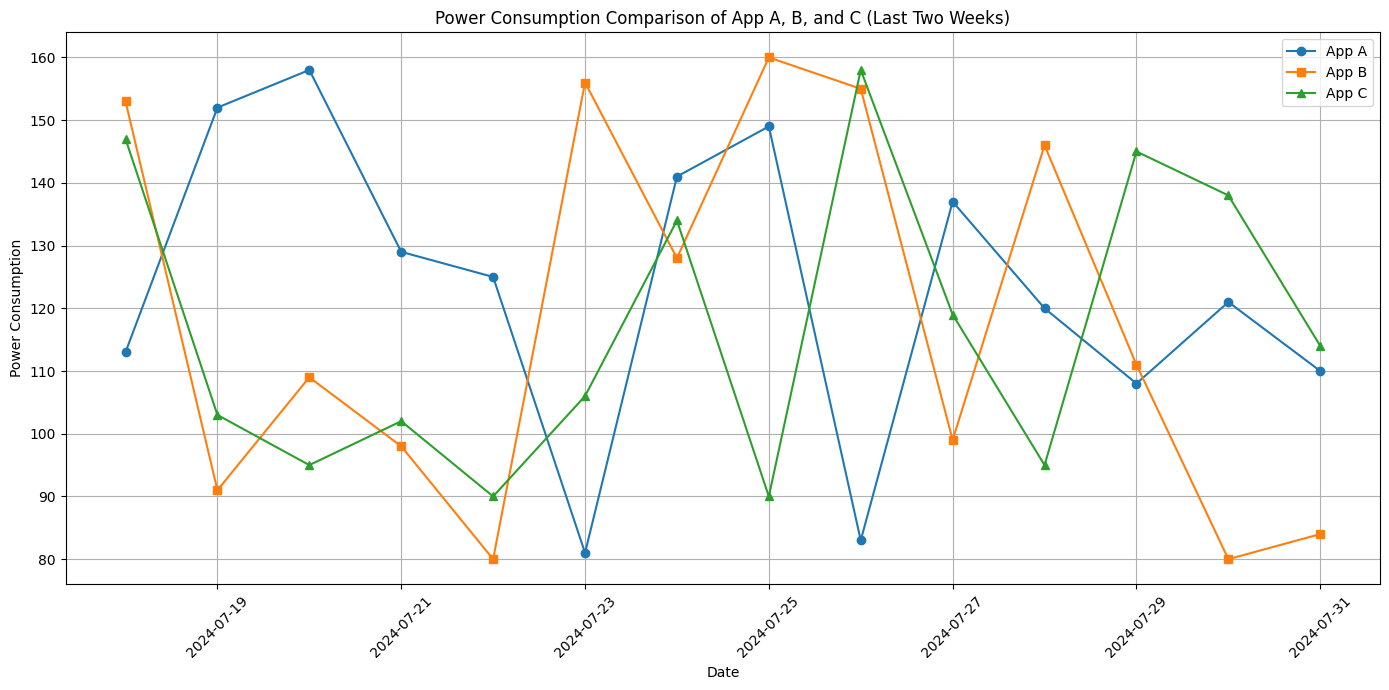

---CODE CHECKER---
"Output from node 'chart_generation':"
'---'
{'code_err': 'None', 'prev_node': 'CHART_GENERATION'}
'\n---\n'
---CHART DESCRIPTION---
1. 차트 개요:
이 차트는 최근 2주간(2024년 7월 18일부터 7월 31일까지) App A, B, C의 일일 전력 소비량을 비교하는 선 그래프입니다. 각 앱은 서로 다른 색상과 마커로 표시되어 있어 쉽게 구분할 수 있습니다.

2. 데이터 분석:
- App A (파란색): 전반적으로 중간 정도의 변동성을 보이며, 7월 20일경 가장 높은 소비량을 기록했습니다.
- App B (주황색): 가장 큰 변동성을 보이며, 7월 25일에 최고점을 기록한 후 급격히 감소하는 추세를 보입니다.
- App C (녹색): 중간 정도의 변동성을 보이며, 7월 26일에 최고점을 기록했습니다.

3. 사용자 요청 연관성:
이 차트는 사용자가 요청한 대로 최근 2주간 App A, B, C의 전력 소비량을 일별로 비교하여 보여주고 있습니다. 각 앱의 소비 패턴과 변화를 더 긴 기간에 걸쳐 볼 수 있어 이전 차트보다 더 포괄적인 정보를 제공합니다.

4. 주요 인사이트:
- 세 앱 모두 상당한 일일 변동성을 보이지만, App B의 변동성이 가장 큽니다.
- 7월 25일부터 26일 사이에 모든 앱의 전력 소비량이 급격히 증가했다가 감소하는 패턴이 관찰됩니다.
- 기간의 후반부(7월 27일 이후)에는 App B의 소비량이 다른 두 앱에 비해 현저히 낮아지는 경향을 보입니다.
- App A와 C는 종종 비슷한 패턴을 보이지만, 특정 날짜에는 상반된 움직임을 보이기도 합니다.

5. 한계점 및 추가 고려사항:
- 2주간의 데이터만으로는 장기적인 추세를 파악하기 어려울 수 있습니다. 더 긴 기간의 데이터가 있다면 계절성이나 장기 패턴을 파악하는 데 도움이 될 것입니다.
- 전력 소비량의 단위가 명시되어 있지 않아 정확한 수치

In [41]:
analyzer.invoke(
    ask=dedent("2주일 치 보여줘")
)

---CALL AGENT---
GENERATE_CHART (사용자가 전력 소비가 가장 큰 지점을 표시해달라고 요청했으므로, 기존 차트에 이 정보를 추가한 새로운 차트 생성이 필요함)
---DECIDE TO CHART GENERATION---
---DECISION: CHART GENERATION---
"Output from node 'agent':"
'---'
{'ask': '전력이 가장 큰 지점을 표시해줘', 'prev_node': 'AGENT'}
'\n---\n'
---ASK REFORMULATION---
{
  "target_apps": ["app_a", "app_b", "app_c"],
  "ask_reformulation": "최근 2주간 app_a, app_b, app_c의 소비 전력을 비교하는 차트를 생성하고, 각 앱별로 전력 소비가 가장 큰 지점을 표시"
}"Output from node 'ask_reformulation':"
'---'
{ 'ask_refo': '최근 2주간 app_a, app_b, app_c의 소비 전력을 비교하는 차트를 생성하고, 각 앱별로 전력 소비가 '
              '가장 큰 지점을 표시',
  'prev_node': 'ASK_REFORMULATION',
  'target_apps': ['app_a', 'app_b', 'app_c']}
'\n---\n'
---CODE GENERATION FOR CHART---
{
    "code": """
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Convert '날짜' column to datetime if not already
df['날짜'] = pd.to_datetime(df['날짜'])

# Get the date of the last day in the dataset
last_date = df['날짜'].max()

# Calculate t

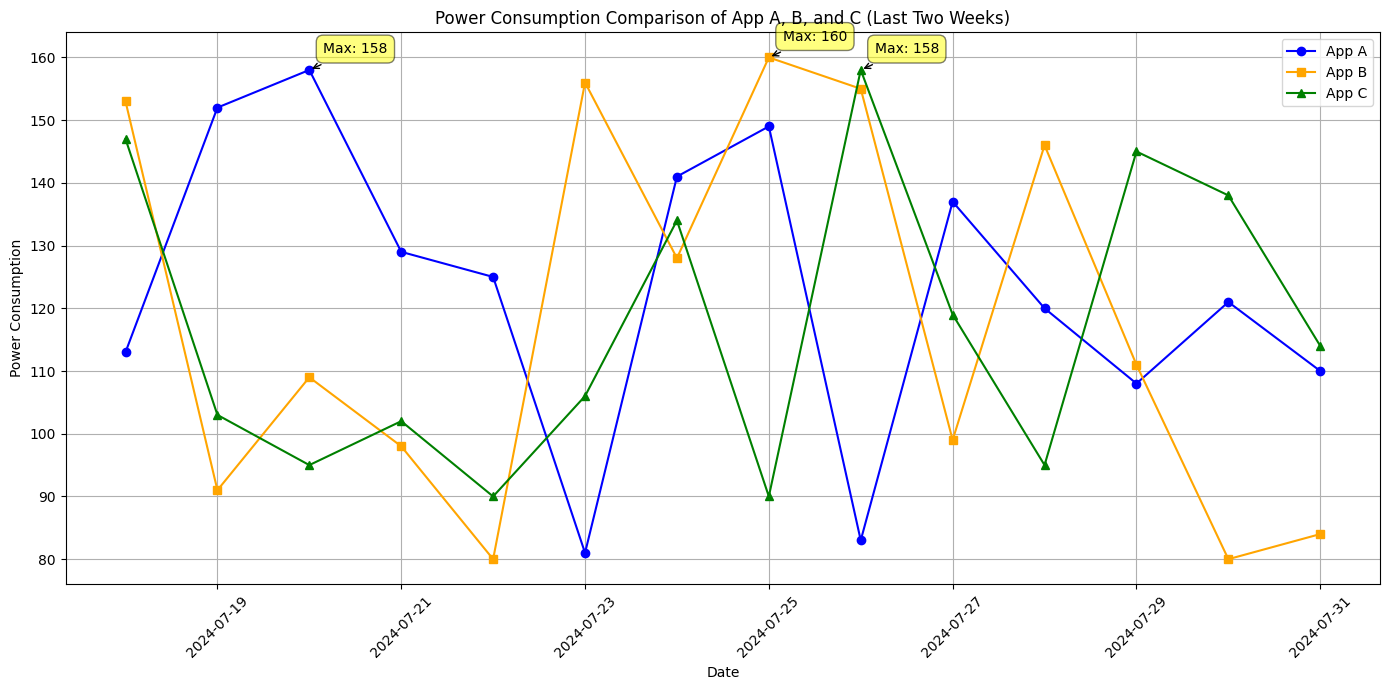

---CODE CHECKER---
"Output from node 'chart_generation':"
'---'
{'code_err': 'None', 'prev_node': 'CHART_GENERATION'}
'\n---\n'
---CHART DESCRIPTION---
1. 차트 개요:
이 차트는 최근 2주간(2024년 7월 18일부터 7월 31일까지) App A, B, C의 일일 전력 소비량을 비교하는 선 그래프입니다. 각 앱은 서로 다른 색상과 마커로 표시되어 있으며, 각 앱의 최대 전력 소비 지점이 강조 표시되어 있습니다.

2. 데이터 분석:
- App A (파란색): 최대 전력 소비량은 158로, 7월 20일경에 기록되었습니다.
- App B (주황색): 최대 전력 소비량은 160으로, 7월 25일에 기록되었습니다.
- App C (녹색): 최대 전력 소비량은 158로, 7월 26일에 기록되었습니다.

3. 사용자 요청 연관성:
이 차트는 사용자가 요청한 대로 최근 2주간 App A, B, C의 전력 소비량을 비교하고 있으며, 각 앱별로 전력 소비가 가장 큰 지점을 명확하게 표시하고 있습니다.

4. 주요 인사이트:
- 세 앱 모두 최대 전력 소비량이 비슷한 수준(158-160)을 보이지만, 발생 시점은 다릅니다.
- App B가 가장 높은 최대 전력 소비량(160)을 기록했지만, 기간의 후반부에는 전력 소비가 크게 감소하는 경향을 보입니다.
- App A와 C는 최대 전력 소비량이 동일하지만, App A는 기간 초반에, App C는 중반에 최대치를 기록했습니다.
- 7월 25일부터 26일 사이에 모든 앱의 전력 소비량이 급격히 증가했다가 감소하는 패턴이 관찰됩니다.

5. 한계점 및 추가 고려사항:
- 최대 전력 소비 지점만 강조되어 있어, 최소 전력 소비 지점이나 평균 소비량 등의 추가 정보가 있으면 더 종합적인 분석이 가능할 것입니다.
- 전력 소비량의 단위가 명시되어 있지 않아 정확한 수치 해석에 제한이 있습니다.
- 각 앱의 특성, 사용자 

In [42]:
analyzer.invoke(
    ask=dedent("전력이 가장 큰 지점을 표시해줘")
)

---CALL AGENT---
GENERATE_CHART (사용자가 가장 큰 전력을 사용한 날짜도 표시해달라고 요청했으므로, 기존 차트에 이 정보를 추가한 새로운 차트 생성이 필요함)
---DECIDE TO CHART GENERATION---
---DECISION: CHART GENERATION---
"Output from node 'agent':"
'---'
{'ask': '가장 큰 전력을 쓴 날짜도 표시해줘', 'prev_node': 'AGENT'}
'\n---\n'
---ASK REFORMULATION---
{
  "target_apps": ["app_a", "app_b", "app_c"],
  "ask_reformulation": "최근 2주간 app_a, app_b, app_c의 소비 전력을 비교하는 차트를 생성하고, 각 앱별로 전력 소비가 가장 큰 지점의 값과 해당 날짜를 표시"
}"Output from node 'ask_reformulation':"
'---'
{ 'ask_refo': '최근 2주간 app_a, app_b, app_c의 소비 전력을 비교하는 차트를 생성하고, 각 앱별로 전력 소비가 '
              '가장 큰 지점의 값과 해당 날짜를 표시',
  'prev_node': 'ASK_REFORMULATION',
  'target_apps': ['app_a', 'app_b', 'app_c']}
'\n---\n'
---CODE GENERATION FOR CHART---
{
    "code": """
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Convert '날짜' column to datetime if not already
df['날짜'] = pd.to_datetime(df['날짜'])

# Get the date of the last day in the dataset
last_date = df['날짜

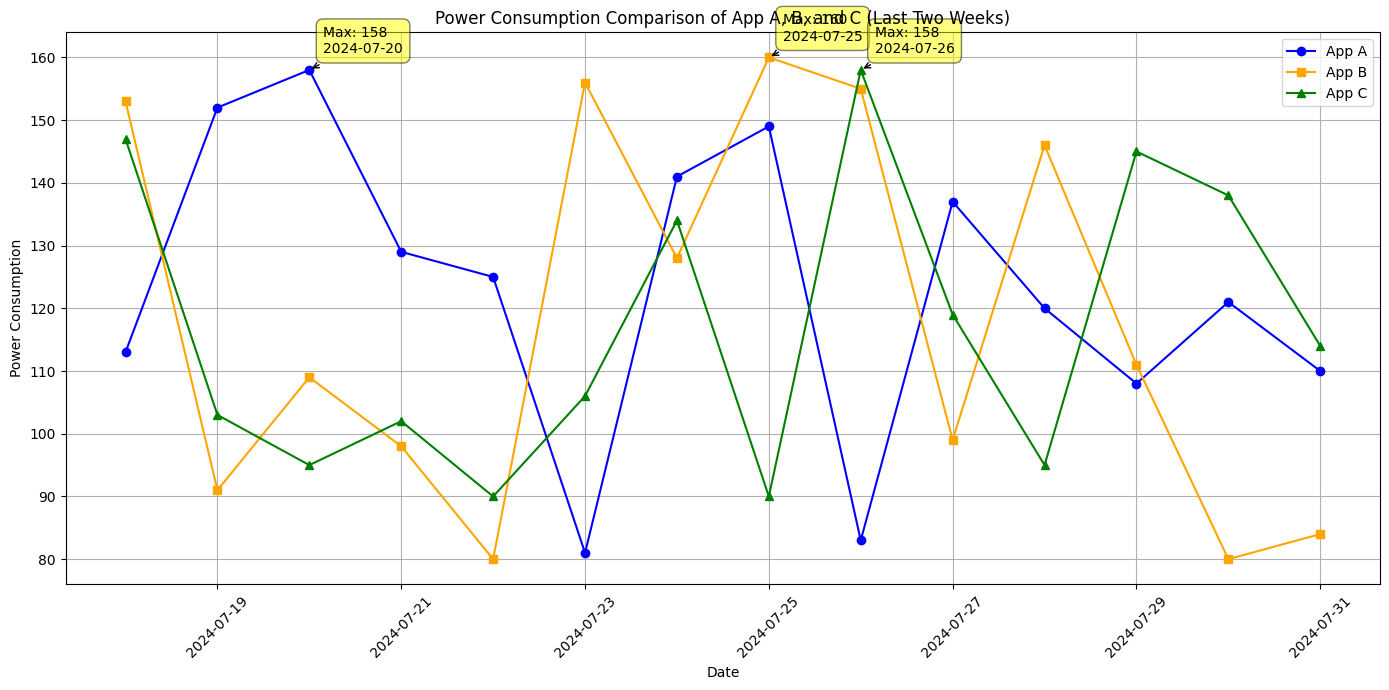

---CODE CHECKER---
"Output from node 'chart_generation':"
'---'
{'code_err': 'None', 'prev_node': 'CHART_GENERATION'}
'\n---\n'
---CHART DESCRIPTION---
1. 차트 개요:
이 차트는 2024년 7월 18일부터 7월 31일까지 2주간 App A, B, C의 일일 전력 소비량을 비교하는 선 그래프입니다. 각 앱은 서로 다른 색상과 마커로 표시되어 있으며, 각 앱의 최대 전력 소비 지점이 값과 날짜와 함께 강조 표시되어 있습니다.

2. 데이터 분석:
- App A (파란색): 최대 전력 소비량은 158로, 2024년 7월 20일에 기록되었습니다.
- App B (주황색): 최대 전력 소비량은 160으로, 2024년 7월 25일에 기록되었습니다.
- App C (녹색): 최대 전력 소비량은 158로, 2024년 7월 26일에 기록되었습니다.

3. 사용자 요청 연관성:
이 차트는 사용자가 요청한 대로 최근 2주간 App A, B, C의 전력 소비량을 비교하고 있으며, 각 앱별로 전력 소비가 가장 큰 지점의 값과 해당 날짜를 명확하게 표시하고 있습니다.

4. 주요 인사이트:
- 세 앱 모두 최대 전력 소비량이 비슷한 수준(158-160)을 보이지만, 발생 시점은 다릅니다.
- App B가 가장 높은 최대 전력 소비량(160)을 기록했으며, 이는 7월 25일에 발생했습니다.
- App A와 C는 최대 전력 소비량이 동일하지만(158), App A는 7월 20일에, App C는 7월 26일에 최대치를 기록했습니다.
- 7월 25일부터 26일 사이에 모든 앱의 전력 소비량이 급격히 증가했다가 감소하는 패턴이 관찰됩니다.
- App B는 최대 소비량 기록 후 급격한 감소 추세를 보이는 반면, App A와 C는 상대적으로 완만한 변화를 보입니다.

5. 한계점 및 추가 고려사항:
- 최대 전력 소비 지점만 강조되어 있어, 최소 전력 소비 지점이나 평균 소비량

In [43]:
analyzer.invoke(
    ask=dedent("가장 큰 전력을 쓴 날짜도 표시해줘")
)

In [ ]:
analyzer.invoke(
    ask=dedent("지난 2주에 대해서만 그려줘")
)

In [ ]:
analyzer.invoke(
    ask=dedent("막대 그래프로 보여줄래?")
)

In [ ]:
analyzer.invoke(
    ask=dedent("지난 3일에 대해 파이 차트를 각각 그려줘")
)

In [ ]:
tool_config = insight_extraction_tools.get_tool_list()
tool_config